<a href="https://colab.research.google.com/github/RochX/comp486-assignments/blob/main/project/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Project
## New York City AirBNB prices

In [11]:
from pathlib import Path
import pandas as pd
import urllib.request

# download the data if it is not downloaded
if not Path("new_york_listings_2024.csv").is_file():
  # here I download the data from my personal git repo for this class instead of using Google Drive
  url = "https://raw.githubusercontent.com/RochX/comp486-assignments/main/project/new_york_listings_2024.csv"
  urllib.request.urlretrieve(url, "new_york_listings_2024.csv")

new_york_listings_2024 = pd.read_csv("new_york_listings_2024.csv")
new_york_listings_2024.head(10)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,rating,bedrooms,beds,baths
0,1312228,Rental unit in Brooklyn · ★5.0 · 1 bedroom,7130382,Walter,Brooklyn,Clinton Hill,40.683710,-73.964610,Private room,55.0,...,2015-12-20,0.03,1,0,0,No License,5.0,1,1,Not specified
1,45277537,Rental unit in New York · ★4.67 · 2 bedrooms ·...,51501835,Jeniffer,Manhattan,Hell's Kitchen,40.766610,-73.988100,Entire home/apt,144.0,...,2023-05-01,0.24,139,364,2,No License,4.67,2,1,1
2,971353993633883038,Rental unit in New York · ★4.17 · 1 bedroom · ...,528871354,Joshua,Manhattan,Chelsea,40.750764,-73.994605,Entire home/apt,187.0,...,2023-12-18,1.67,1,343,6,Exempt,4.17,1,2,1
3,3857863,Rental unit in New York · ★4.64 · 1 bedroom · ...,19902271,John And Catherine,Manhattan,Washington Heights,40.835600,-73.942500,Private room,120.0,...,2023-09-17,1.38,2,363,12,No License,4.64,1,1,1
4,40896611,Condo in New York · ★4.91 · Studio · 1 bed · 1...,61391963,Stay With Vibe,Manhattan,Murray Hill,40.751120,-73.978600,Entire home/apt,85.0,...,2023-12-03,0.24,133,335,3,No License,4.91,Studio,1,1
5,49584983,Rental unit in New York · ★5.0 · 1 bedroom · 1...,51501835,Jeniffer,Manhattan,Hell's Kitchen,40.759950,-73.992960,Entire home/apt,115.0,...,2023-07-29,0.16,139,276,2,No License,5.0,1,1,1
6,45457047,Rental unit in New York · ★4.33 · Studio · 1 b...,51501835,Jeniffer,Manhattan,Hell's Kitchen,40.767370,-73.987870,Entire home/apt,105.0,...,2022-08-31,0.10,139,364,0,No License,4.33,Studio,1,1
7,45847112,Rental unit in New York · ★4.50 · 2 bedrooms ·...,51501835,Jeniffer,Manhattan,Hell's Kitchen,40.765190,-73.990130,Entire home/apt,130.0,...,2023-05-30,0.26,139,295,2,No License,4.50,2,2,1
8,19280212,Rental unit in Brooklyn · ★4.79 · 1 bedroom · ...,2526182,Margaux,Brooklyn,Williamsburg,40.711530,-73.953120,Private room,90.0,...,2023-10-01,0.24,2,5,2,No License,4.79,1,1,1
9,895681617796889995,Rental unit in Brooklyn · ★4.67 · 1 bedroom · ...,14251313,Kristin,Brooklyn,Sunset Park,40.658913,-73.989590,Entire home/apt,292.0,...,2023-10-19,1.71,1,365,12,No License,4.67,1,1,1


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,rating,bedrooms,beds,baths
0,1312228,Rental unit in Brooklyn · ★5.0 · 1 bedroom,7130382,Walter,Brooklyn,Clinton Hill,40.68371,-73.96461,Private room,55.00000,30,3,2015-12-20,0.03000,1,0,0,No License,5.0,1,1,Not specified
1,45277537,Rental unit in New York · ★4.67 · 2 bedrooms ·...,51501835,Jeniffer,Manhattan,Hell's Kitchen,40.76661,-73.98810,Entire home/apt,144.00000,30,9,2023-05-01,0.24000,139,364,2,No License,4.67,2,1,1
2,971353993633883038,Rental unit in New York · ★4.17 · 1 bedroom · ...,528871354,Joshua,Manhattan,Chelsea,40.75076,-73.99461,Entire home/apt,187.00000,2,6,2023-12-18,1.67000,1,343,6,Exempt,4.17,1,2,1
3,3857863,Rental unit in New York · ★4.64 · 1 bedroom · ...,19902271,John And Catherine,Manhattan,Washington Heights,40.83560,-73.94250,Private room,120.00000,30,156,2023-09-17,1.38000,2,363,12,No License,4.64,1,1,1
4,40896611,Condo in New York · ★4.91 · Studio · 1 bed · 1...,61391963,Stay With Vibe,Manhattan,Murray Hill,40.75112,-73.97860,Entire home/apt,85.00000,30,11,2023-12-03,0.24000,133,335,3,No License,4.91,Studio,1,1
5,49584983,Rental unit in New York · ★5.0 · 1 bedroom · 1...,51501835,Jeniffer,Manhattan,Hell's Kitchen,40.75995,-73.99296,Entire home/apt,115.00000,30,5,2023-07-29,0.16000,139,276,2,No License,5.0,1,1,1
6,45457047,Rental unit in New York · ★4.33 · Studio · 1 b...,51501835,Jeniffer,Manhattan,Hell's Kitchen,40.76737,-73.98787,Entire home/apt,105.00000,30,3,2022-08-31,0.10000,139,364,0,No License,4.33,Studio,1,1
7,45847112,Rental unit in New York · ★4.50 · 2 bedrooms ·...,51501835,Jeniffer,Manhattan,Hell's Kitchen,40.76519,-73.99013,Entire home/apt,130.00000,30,10,2023-05-30,0.26000,139,295,2,No License,4.50,2,2,1
8,19280212,Rental unit in Brooklyn · ★4.79 · 1 bedroom · ...,2526182,Margaux,Brooklyn,Williamsburg,40.71153,-73.95312,Private room,90.00000,30,19,2023-10-01,0.24000,2,5,2,No License,4.79,1,1,1
9,895681617796889995,Rental unit in Brooklyn · ★4.67 · 1 bedroom · ...,14251313,Kristin,Brooklyn,Sunset Park,40.65891,-73.98959,Entire home/apt,292.00000,30,12,2023-10-19,1.71000,1,365,12,No License,4.67,1,1,1


Get some information on the data.

In [12]:
new_york_listings_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   name                            20758 non-null  object 
 2   host_id                         20758 non-null  int64  
 3   host_name                       20758 non-null  object 
 4   neighbourhood_group             20758 non-null  object 
 5   neighbourhood                   20758 non-null  object 
 6   latitude                        20758 non-null  float64
 7   longitude                       20758 non-null  float64
 8   room_type                       20758 non-null  object 
 9   price                           20758 non-null  float64
 10  minimum_nights                  20758 non-null  int64  
 11  number_of_reviews               20758 non-null  int64  
 12  last_review                     

Take a look at the categorical features listed (besides `name` and `host_name`).

In [13]:
for col in list(new_york_listings_2024.drop(["name", "host_name"], axis=1).select_dtypes(include=["object"])):
  if col != "baths":
    print(new_york_listings_2024.value_counts(col), end="\n\n\n")
  else:
    print(new_york_listings_2024.value_counts(col))

neighbourhood_group
Manhattan        8038
Brooklyn         7719
Queens           3761
Bronx             949
Staten Island     291
dtype: int64


neighbourhood
Bedford-Stuyvesant            1586
Harlem                        1063
Williamsburg                   969
Midtown                        942
Hell's Kitchen                 867
                              ... 
Bay Terrace, Staten Island       1
Navy Yard                        1
Lighthouse Hill                  1
Chelsea, Staten Island           1
Neponsit                         1
Length: 221, dtype: int64


room_type
Entire home/apt    11549
Private room        8804
Shared room          293
Hotel room           112
dtype: int64


last_review
2023-09-04    326
2023-12-03    255
2023-12-17    244
2023-09-05    223
2023-11-30    212
             ... 
2020-04-17      1
2020-04-16      1
2020-04-15      1
2020-04-14      1
2021-03-21      1
Length: 1878, dtype: int64


license
No License            17569
Exempt                 2135


We see that some of these "categorical" features are actually numeric except with "missing data" or something similar as actual data.
These features are `rating`, `bedrooms`, and `baths`.
We can make the following corrections for each feature:
- `rating`: Convert `No Rating` and `New ` into `NaN`
- `bedrooms`: Convert `Studio` into `1`. Studio apartments are basically 1 bedroom apartments, but the bed isn't in its own room.
- `baths`: Convert `Not specified` into `NaN`.

Let's clean the data in accordance to this.

In [14]:
cleaned_data = new_york_listings_2024
cleaned_data["rating"] = new_york_listings_2024["rating"].replace({"No rating": None, "New ": None})
cleaned_data["bedrooms"] = new_york_listings_2024["bedrooms"].replace({"Studio": "1"})
cleaned_data["baths"] = new_york_listings_2024["baths"].replace({"Not specified": None})

obj_to_num_cols = ["rating", "bedrooms", "baths"]
cleaned_data[obj_to_num_cols] = cleaned_data[obj_to_num_cols].apply(pd.to_numeric)

cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   name                            20758 non-null  object 
 2   host_id                         20758 non-null  int64  
 3   host_name                       20758 non-null  object 
 4   neighbourhood_group             20758 non-null  object 
 5   neighbourhood                   20758 non-null  object 
 6   latitude                        20758 non-null  float64
 7   longitude                       20758 non-null  float64
 8   room_type                       20758 non-null  object 
 9   price                           20758 non-null  float64
 10  minimum_nights                  20758 non-null  int64  
 11  number_of_reviews               20758 non-null  int64  
 12  last_review                     

Now that `rating`, `bedrooms`, and `baths` are numeric values, let's try creating a correlation matrix for `price`.

In [15]:
cleaned_data.corr()["price"]

<ipython-input-5-d7c83fdcafbc>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cleaned_data.corr()["price"]


id                                0.002372
host_id                          -0.005987
latitude                         -0.001143
longitude                        -0.033460
price                             1.000000
minimum_nights                   -0.006527
number_of_reviews                -0.012588
reviews_per_month                -0.009917
calculated_host_listings_count   -0.007333
availability_365                  0.020151
number_of_reviews_ltm            -0.011263
rating                           -0.004692
bedrooms                          0.074036
beds                              0.066882
baths                             0.066048
Name: price, dtype: float64

<ipython-input-15-d7c83fdcafbc>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cleaned_data.corr()["price"]


id                                0.00237
host_id                          -0.00599
latitude                         -0.00114
longitude                        -0.03346
price                             1.00000
minimum_nights                   -0.00653
number_of_reviews                -0.01259
reviews_per_month                -0.00992
calculated_host_listings_count   -0.00733
availability_365                  0.02015
number_of_reviews_ltm            -0.01126
rating                           -0.00469
bedrooms                          0.07404
beds                              0.06688
baths                             0.06605
Name: price, dtype: float64

In [16]:
cleaned_data.drop(["id", "host_id"], axis=1).describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,rating,bedrooms,beds,baths
count,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,17006.000000,20758.000000,20758.000000,20745.000000
mean,40.726798,-73.939161,187.776616,28.558435,42.642596,1.257910,18.844108,205.990317,10.852105,4.734253,1.394161,1.723721,1.177995
std,0.060294,0.061403,1022.797208,33.536518,73.561654,1.904661,70.910834,135.087768,21.357071,0.294387,0.788123,1.212272,0.480456
min,40.500314,-74.249840,10.000000,1.000000,1.000000,0.010000,1.000000,0.000000,0.000000,1.750000,1.000000,1.000000,0.000000
25%,40.684150,-73.980710,80.000000,30.000000,4.000000,0.210000,1.000000,87.000000,1.000000,4.640000,1.000000,1.000000,1.000000
50%,40.722820,-73.949587,125.000000,30.000000,14.000000,0.650000,2.000000,215.000000,3.000000,4.810000,1.000000,1.000000,1.000000
75%,40.763098,-73.917460,199.000000,30.000000,49.000000,1.800000,5.000000,353.000000,15.000000,4.930000,2.000000,2.000000,1.000000
max,40.911147,-73.713650,100000.000000,1250.000000,1865.000000,75.490000,713.000000,365.000000,1075.000000,5.000000,15.000000,42.000000,15.500000


,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,rating,bedrooms,beds,baths
count,20758.00000,20758.00000,20758.00000,20758.00000,20758.00000,20758.00000,20758.00000,20758.00000,20758.00000,17006.00000,20758.00000,20758.00000,20745.00000
mean,40.72680,-73.93916,187.77662,28.55844,42.64260,1.25791,18.84411,205.99032,10.85211,4.73425,1.39416,1.72372,1.17799
std,0.06029,0.06140,1022.79721,33.53652,73.56165,1.90466,70.91083,135.08777,21.35707,0.29439,0.78812,1.21227,0.48046
min,40.50031,-74.24984,10.00000,1.00000,1.00000,0.01000,1.00000,0.00000,0.00000,1.75000,1.00000,1.00000,0.00000
25%,40.68415,-73.98071,80.00000,30.00000,4.00000,0.21000,1.00000,87.00000,1.00000,4.64000,1.00000,1.00000,1.00000
50%,40.72282,-73.94959,125.00000,30.00000,14.00000,0.65000,2.00000,215.00000,3.00000,4.81000,1.00000,1.00000,1.00000
75%,40.76310,-73.91746,199.00000,30.00000,49.00000,1.80000,5.00000,353.00000,15.00000,4.93000,2.00000,2.00000,1.00000
max,40.91115,-73.71365,100000.00000,1250.00000,1865.00000,75.49000,713.00000,365.00000,1075.00000,5.00000,15.00000,42.00000,15.50000


<Axes: >

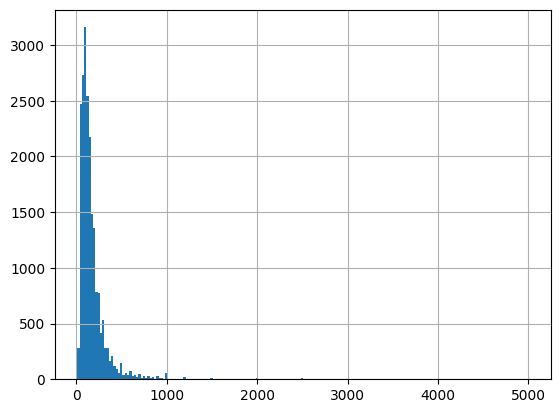

<Axes: >

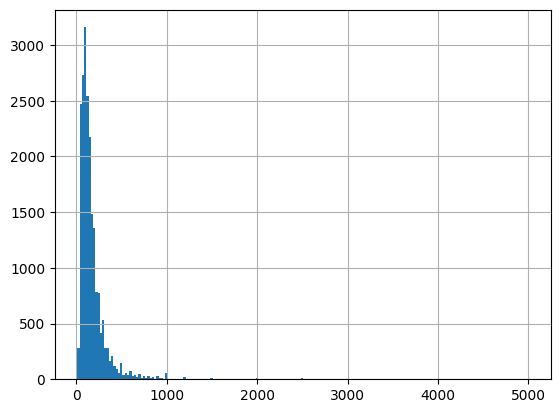

In [17]:
low_data = cleaned_data[cleaned_data['price'] <= 5000]
high_data = cleaned_data[cleaned_data['price'] > 5000]
low_data['price'].hist(bins=200)

<Axes: >

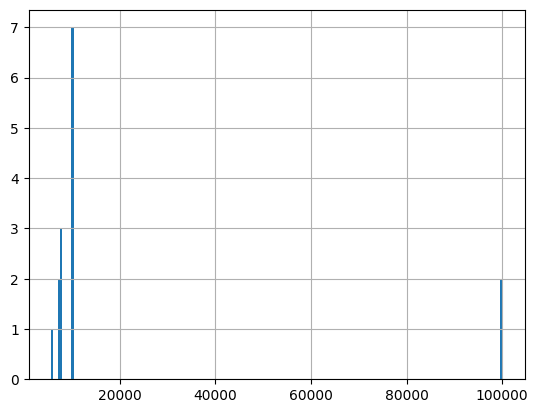

<Axes: >

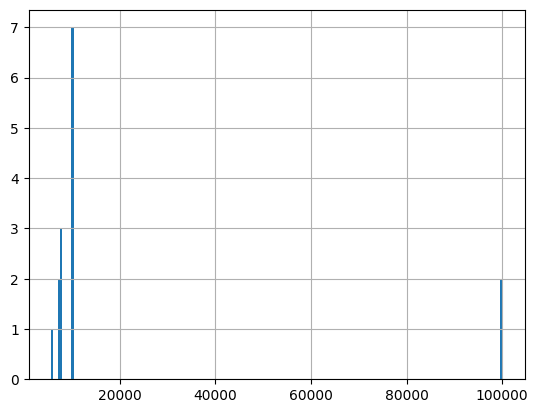

In [18]:
high_data['price'].hist(bins=200)

In [19]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np

filtered_data = cleaned_data[cleaned_data['price'] <= 5000]
numeric_feature_names = list(filtered_data.select_dtypes(include=["int64", "float64"]).drop(["id", "host_id"], axis=1))

scaler = make_column_transformer(
    (MinMaxScaler(), numeric_feature_names),
    remainder='passthrough'
)
scaler.set_output(transform="pandas")
pd.set_option('display.float_format', lambda x: '%.5f' % x)

scaler.fit_transform(filtered_data).corr()

<ipython-input-9-73f99db7a723>:15: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  scaler.fit_transform(filtered_data).corr()


,minmaxscaler__latitude,minmaxscaler__longitude,minmaxscaler__price,minmaxscaler__minimum_nights,minmaxscaler__number_of_reviews,minmaxscaler__reviews_per_month,minmaxscaler__calculated_host_listings_count,minmaxscaler__availability_365,minmaxscaler__number_of_reviews_ltm,minmaxscaler__rating,minmaxscaler__bedrooms,minmaxscaler__beds,minmaxscaler__baths,remainder__id,remainder__host_id
minmaxscaler__latitude,1.00000,0.04632,0.01675,0.00418,-0.04820,-0.04186,0.07009,-0.00531,-0.04178,-0.07322,-0.08082,-0.07000,-0.03476,0.00962,0.01192
minmaxscaler__longitude,0.04632,1.00000,-0.16193,0.02418,0.00554,0.04242,-0.07227,0.06205,0.03356,0.00464,0.03320,0.03576,-0.01143,0.06830,0.12249
minmaxscaler__price,0.01675,-0.16193,1.00000,-0.03845,-0.04324,-0.02401,-0.02028,0.04542,-0.03735,0.08817,0.39558,0.37017,0.35917,0.03314,-0.01009
minmaxscaler__minimum_nights,0.00418,0.02418,-0.03845,1.00000,-0.05920,-0.12253,0.01501,0.03473,-0.09263,-0.01006,-0.01222,-0.02658,0.00747,-0.07362,-0.07238
minmaxscaler__number_of_reviews,-0.04820,0.00554,-0.04324,-0.05920,1.00000,0.63142,-0.11468,-0.05038,0.60564,0.06644,-0.02637,0.03523,-0.05580,-0.28295,-0.13991
minmaxscaler__reviews_per_month,-0.04186,0.04242,-0.02401,-0.12253,0.63142,1.00000,-0.10867,-0.04063,0.84980,0.05770,0.00484,0.04763,-0.02786,0.13798,0.17041
minmaxscaler__calculated_host_listings_count,0.07009,-0.07227,-0.02028,0.01501,-0.11468,-0.10867,1.00000,0.04640,-0.09160,-0.14954,-0.02935,-0.07104,-0.00755,-0.01083,-0.04999
minmaxscaler__availability_365,-0.00531,0.06205,0.04542,0.03473,-0.05038,-0.04063,0.04640,1.00000,-0.04910,-0.05439,0.06671,0.06503,0.04968,0.10111,0.08260
minmaxscaler__number_of_reviews_ltm,-0.04178,0.03356,-0.03735,-0.09263,0.60564,0.84980,-0.09160,-0.04910,1.00000,0.06988,-0.00618,0.03213,-0.03010,0.03734,0.10096
minmaxscaler__rating,-0.07322,0.00464,0.08817,-0.01006,0.06644,0.05770,-0.14954,-0.05439,0.06988,1.00000,0.02959,0.01147,0.01701,0.00008,-0.11601


<ipython-input-19-73f99db7a723>:15: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  scaler.fit_transform(filtered_data).corr()


,minmaxscaler__latitude,minmaxscaler__longitude,minmaxscaler__price,minmaxscaler__minimum_nights,minmaxscaler__number_of_reviews,minmaxscaler__reviews_per_month,minmaxscaler__calculated_host_listings_count,minmaxscaler__availability_365,minmaxscaler__number_of_reviews_ltm,minmaxscaler__rating,minmaxscaler__bedrooms,minmaxscaler__beds,minmaxscaler__baths,remainder__id,remainder__host_id
minmaxscaler__latitude,1.00000,0.04632,0.01675,0.00418,-0.04820,-0.04186,0.07009,-0.00531,-0.04178,-0.07322,-0.08082,-0.07000,-0.03476,0.00962,0.01192
minmaxscaler__longitude,0.04632,1.00000,-0.16193,0.02418,0.00554,0.04242,-0.07227,0.06205,0.03356,0.00464,0.03320,0.03576,-0.01143,0.06830,0.12249
minmaxscaler__price,0.01675,-0.16193,1.00000,-0.03845,-0.04324,-0.02401,-0.02028,0.04542,-0.03735,0.08817,0.39558,0.37017,0.35917,0.03314,-0.01009
minmaxscaler__minimum_nights,0.00418,0.02418,-0.03845,1.00000,-0.05920,-0.12253,0.01501,0.03473,-0.09263,-0.01006,-0.01222,-0.02658,0.00747,-0.07362,-0.07238
minmaxscaler__number_of_reviews,-0.04820,0.00554,-0.04324,-0.05920,1.00000,0.63142,-0.11468,-0.05038,0.60564,0.06644,-0.02637,0.03523,-0.05580,-0.28295,-0.13991
minmaxscaler__reviews_per_month,-0.04186,0.04242,-0.02401,-0.12253,0.63142,1.00000,-0.10867,-0.04063,0.84980,0.05770,0.00484,0.04763,-0.02786,0.13798,0.17041
minmaxscaler__calculated_host_listings_count,0.07009,-0.07227,-0.02028,0.01501,-0.11468,-0.10867,1.00000,0.04640,-0.09160,-0.14954,-0.02935,-0.07104,-0.00755,-0.01083,-0.04999
minmaxscaler__availability_365,-0.00531,0.06205,0.04542,0.03473,-0.05038,-0.04063,0.04640,1.00000,-0.04910,-0.05439,0.06671,0.06503,0.04968,0.10111,0.08260
minmaxscaler__number_of_reviews_ltm,-0.04178,0.03356,-0.03735,-0.09263,0.60564,0.84980,-0.09160,-0.04910,1.00000,0.06988,-0.00618,0.03213,-0.03010,0.03734,0.10096
minmaxscaler__rating,-0.07322,0.00464,0.08817,-0.01006,0.06644,0.05770,-0.14954,-0.05439,0.06988,1.00000,0.02959,0.01147,0.01701,0.00008,-0.11601


In [20]:
pd.set_option('display.max_columns', None)
cleaned_data[cleaned_data['price'] > 187*40]['host_name']

901      The Gregory Hotel
2952                 Sarah
3026                   Rom
3140     The Gregory Hotel
3990                 Bobbi
4528     The Gregory Hotel
4967                  John
5492                 Bobbi
6874                 Chris
7857             Elizabeth
10894                 Tito
11261    The Knickerbocker
Name: host_name, dtype: object

901      The Gregory Hotel
2952                 Sarah
3026                   Rom
3140     The Gregory Hotel
3990                 Bobbi
4528     The Gregory Hotel
4967                  John
5492                 Bobbi
6874                 Chris
7857             Elizabeth
10894                 Tito
11261    The Knickerbocker
Name: host_name, dtype: object

In [21]:
cleaned_data["price_per_night"] = cleaned_data["price"] / cleaned_data["minimum_nights"]
cleaned_data["price_times_night"] = cleaned_data["price"] * cleaned_data["minimum_nights"]
cleaned_data["price_squared_times_night"] = cleaned_data["price"]**2 * cleaned_data["minimum_nights"]
cleaned_data["price_times_night_squared"] = cleaned_data["price"] * cleaned_data["minimum_nights"]**2

filtered_data = cleaned_data[cleaned_data['price'] <= 5000]
filtered_data.corr()

<ipython-input-21-dcef2a3581f9>:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  filtered_data.corr()


,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,rating,bedrooms,beds,baths,price_per_night,price_times_night,price_squared_times_night,price_times_night_squared
id,1.00000,0.42245,0.00962,0.06830,0.03314,-0.07362,-0.28295,0.13798,-0.01083,0.10111,0.03734,0.00008,0.07049,0.04107,0.04094,0.10277,-0.05072,-0.02228,-0.01382
host_id,0.42245,1.00000,0.01192,0.12249,-0.01009,-0.07238,-0.13991,0.17041,-0.04999,0.08260,0.10096,-0.11601,0.04803,0.05670,0.01064,0.12091,-0.07932,-0.02407,-0.01268
latitude,0.00962,0.01192,1.00000,0.04632,0.01675,0.00418,-0.04820,-0.04186,0.07009,-0.00531,-0.04178,-0.07322,-0.08082,-0.07000,-0.03476,0.04651,0.00058,0.00325,0.01484
longitude,0.06830,0.12249,0.04632,1.00000,-0.16193,0.02418,0.00554,0.04242,-0.07227,0.06205,0.03356,0.00464,0.03320,0.03576,-0.01143,-0.10909,-0.08316,-0.04977,-0.01320
price,0.03314,-0.01009,0.01675,-0.16193,1.00000,-0.03845,-0.04324,-0.02401,-0.02028,0.04542,-0.03735,0.08817,0.39558,0.37017,0.35917,0.44146,0.57920,0.69678,0.06170
minimum_nights,-0.07362,-0.07238,0.00418,0.02418,-0.03845,1.00000,-0.05920,-0.12253,0.01501,0.03473,-0.09263,-0.01006,-0.01222,-0.02658,0.00747,-0.18689,0.56177,0.09505,0.78069
number_of_reviews,-0.28295,-0.13991,-0.04820,0.00554,-0.04324,-0.05920,1.00000,0.63142,-0.11468,-0.05038,0.60564,0.06644,-0.02637,0.03523,-0.05580,0.01819,-0.05585,-0.02982,-0.01916
reviews_per_month,0.13798,0.17041,-0.04186,0.04242,-0.02401,-0.12253,0.63142,1.00000,-0.10867,-0.04063,0.84980,0.05770,0.00484,0.04763,-0.02786,0.11694,-0.09536,-0.04022,-0.02392
calculated_host_listings_count,-0.01083,-0.04999,0.07009,-0.07227,-0.02028,0.01501,-0.11468,-0.10867,1.00000,0.04640,-0.09160,-0.14954,-0.02935,-0.07104,-0.00755,-0.00641,-0.01288,-0.01382,-0.01020
availability_365,0.10111,0.08260,-0.00531,0.06205,0.04542,0.03473,-0.05038,-0.04063,0.04640,1.00000,-0.04910,-0.05439,0.06671,0.06503,0.04968,0.01884,0.04039,0.01167,0.01136
